# Train a JointVAE model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch

use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to your device

#### Prepare data list

In [4]:
!ls data

dress_dresslen_train_test_splits.json	dress_sleeve_train_test_splits.json
dress_sleevelen_train_test_splits.json	loadable_women_primary_dress.csv


#### Create list of image paths

In [5]:
loadable_dresses = list(np.loadtxt('data/loadable_women_primary_dress.csv',delimiter=',',skiprows=1,dtype='str'))

In [6]:
print(len(loadable_dresses))

102125


In [7]:
loadable_dresses[:5]

['/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/4/6418008_9882769.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/6/6627534_9864695.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/7/6772508_9949243.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/7/6758001_9588597.jpg',
 '/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/6/6637527_9387666.jpg']

In [8]:
bad_data = ['/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/2/723739_1342692.jpg']

for bad in bad_data:
    if bad in loadable_dresses:
        del loadable_dresses[loadable_dresses.index(bad)]
        
print(len(loadable_dresses))

102124


In [9]:
'/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/7/2/723739_1342692.jpg' in loadable_dresses

False

#### Split into train and test set

In [10]:
#image_paths_train = loadable_dresses[:int(len(loadable_dresses)*0.87)]
#image_paths_test = loadable_dresses[int(len(loadable_dresses)*0.87):]
image_paths_train = loadable_dresses[:88800]
image_paths_test = loadable_dresses[88800:-124]


print(f"Number of train image paths: {len(image_paths_train):,d}")
print(f"Number of test image paths: {len(image_paths_test):,d}")
print()
print("Sample paths:")
print(image_paths_train[0])
print(image_paths_train[-1])
print(image_paths_test[0])
print(image_paths_test[-1])

Number of train image paths: 88,800
Number of test image paths: 13,200

Sample paths:
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/6/4/6418008_9882769.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/2/529420_884192.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/5/2/527981_1034607.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/3/4/341494_806784.jpg


In [27]:
from torchvision import transforms
from utils.dataloader_tools import get_imagelist_dataloader, ImageListDataset

BATCH_SIZE = 200

composed = transforms.Compose([transforms.CenterCrop((90,90)),transforms.Resize((64,64)),transforms.ToTensor()])

train_dataset = ImageListDataset(image_paths_train, cut_from='top', cut_amount=90, transform=composed)
test_dataset = ImageListDataset(image_paths_test, cut_from='top', cut_amount=90, transform=composed)

train_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=train_dataset)
test_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=test_dataset)

### Define latent distribution of the model

In [13]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 5,
               'disc': [5]}

### Build a model

In [14]:
!ls jointvae

decoder_scratchpad.py  models_128_v3.py			models_64_xstyle.py
encoder_scratchpad.py  models_128_v4.py			models.py
__init__.py	       models_64_xstyle_finished_v1.py	__pycache__
models_128_v1.py       models_64_xstyle_int_debug.py	training_debug.py
models_128_v2.py       models_64_xstyle_int_nd.py	training.py


In [15]:
from jointvae.models_64_xstyle_int_nd import VAE

model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64), use_cuda=use_cuda)

In [16]:
#print(model)

### Train the model

In [17]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, amsgrad=True) # added amsgrad # orig lr 5e-4

In [18]:
from jointvae.training import Trainer
#from jointvae.training_debug import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 26.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 26.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,
                 use_cuda=use_cuda)

#### Initialize visualizer

In [25]:
from viz.visualize import Visualizer

# Build a visualizer which will be passed to trainer to visualize progress during training
viz = Visualizer(model)
viz.save_image=False

In [20]:
trainer.train(train_loader, epochs=50, save_training_gif=None)

0/88800	Loss: 2825.900
10000/88800	Loss: 2694.615
20000/88800	Loss: 2213.129
30000/88800	Loss: 2116.085
40000/88800	Loss: 2083.662
50000/88800	Loss: 2055.112
60000/88800	Loss: 2042.186
70000/88800	Loss: 2027.500
80000/88800	Loss: 1995.740
Epoch: 1 Average loss: 2137.75
0/88800	Loss: 1986.889
10000/88800	Loss: 1940.830
20000/88800	Loss: 1912.530
30000/88800	Loss: 1901.730
40000/88800	Loss: 1889.362
50000/88800	Loss: 1886.011
60000/88800	Loss: 1881.908
70000/88800	Loss: 1871.534
80000/88800	Loss: 1874.582
Epoch: 2 Average loss: 1893.27
0/88800	Loss: 1843.563
10000/88800	Loss: 1871.553
20000/88800	Loss: 1867.426
30000/88800	Loss: 1867.457
40000/88800	Loss: 1860.321
50000/88800	Loss: 1862.705
60000/88800	Loss: 1866.560
70000/88800	Loss: 1855.601
80000/88800	Loss: 1859.470
Epoch: 3 Average loss: 1863.02
0/88800	Loss: 1862.709
10000/88800	Loss: 1856.785
20000/88800	Loss: 1854.156
30000/88800	Loss: 1848.164
40000/88800	Loss: 1855.374
50000/88800	Loss: 1853.921
60000/88800	Loss: 1845.641
70000

30000/88800	Loss: 1742.677
40000/88800	Loss: 1737.001
50000/88800	Loss: 1733.593
60000/88800	Loss: 1733.100
70000/88800	Loss: 1728.453
80000/88800	Loss: 1734.971
Epoch: 31 Average loss: 1735.43
0/88800	Loss: 1740.771
10000/88800	Loss: 1731.371
20000/88800	Loss: 1735.082
30000/88800	Loss: 1733.317
40000/88800	Loss: 1728.185
50000/88800	Loss: 1736.880
60000/88800	Loss: 1735.160
70000/88800	Loss: 1731.450
80000/88800	Loss: 1732.512
Epoch: 32 Average loss: 1732.35
0/88800	Loss: 1729.218
10000/88800	Loss: 1730.922
20000/88800	Loss: 1732.844
30000/88800	Loss: 1725.473
40000/88800	Loss: 1729.945
50000/88800	Loss: 1725.628
60000/88800	Loss: 1728.206
70000/88800	Loss: 1729.623
80000/88800	Loss: 1730.606
Epoch: 33 Average loss: 1729.30
0/88800	Loss: 1742.096
10000/88800	Loss: 1727.380
20000/88800	Loss: 1727.116
30000/88800	Loss: 1726.529
40000/88800	Loss: 1724.611
50000/88800	Loss: 1721.483
60000/88800	Loss: 1730.509
70000/88800	Loss: 1727.846
80000/88800	Loss: 1729.412
Epoch: 34 Average loss: 1

In [21]:
print('hi')

hi


### Visualize

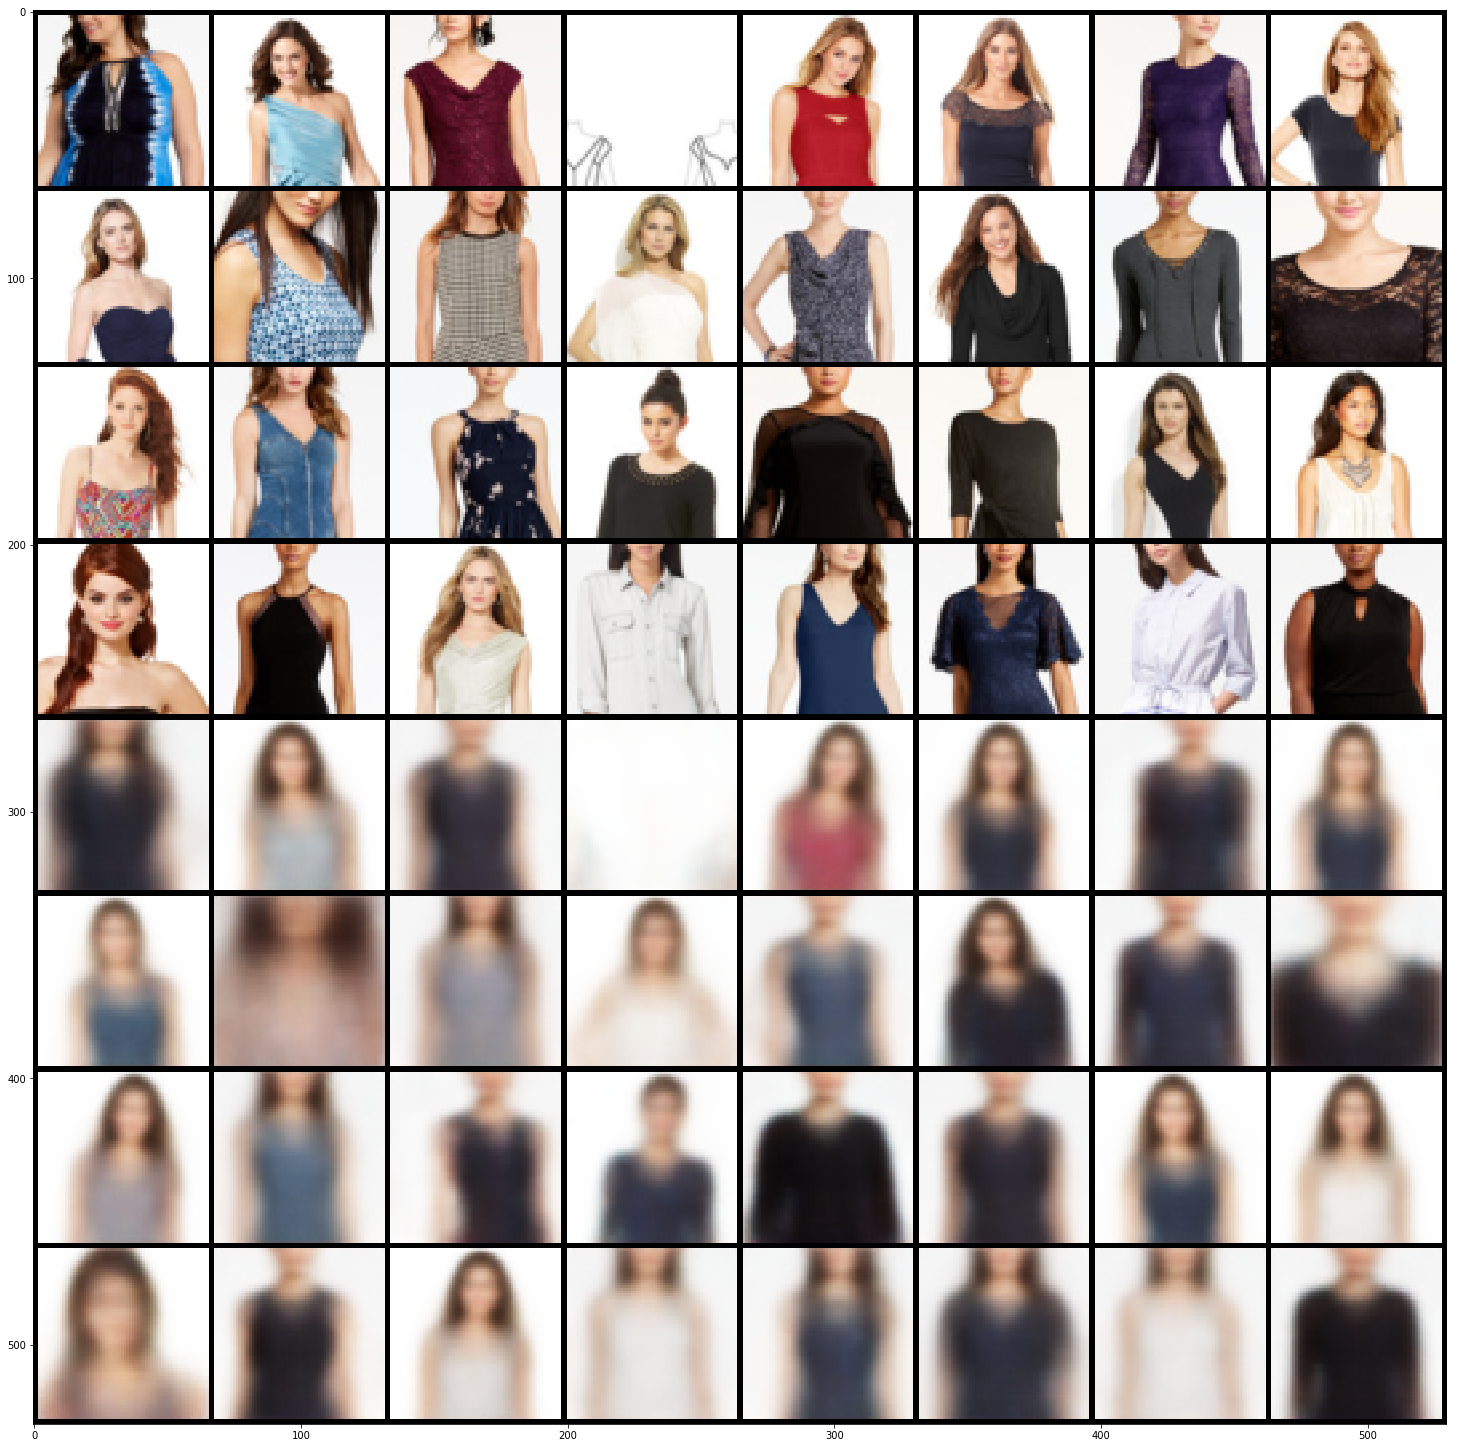

In [28]:
# Plot reconstructions
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a batch of data
for batch, labels in test_loader:
    break

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(batch)

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(recon.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/croptop_xint_64_e50_b200_c5d5_gam26_reconstructions.png",dpi=200)

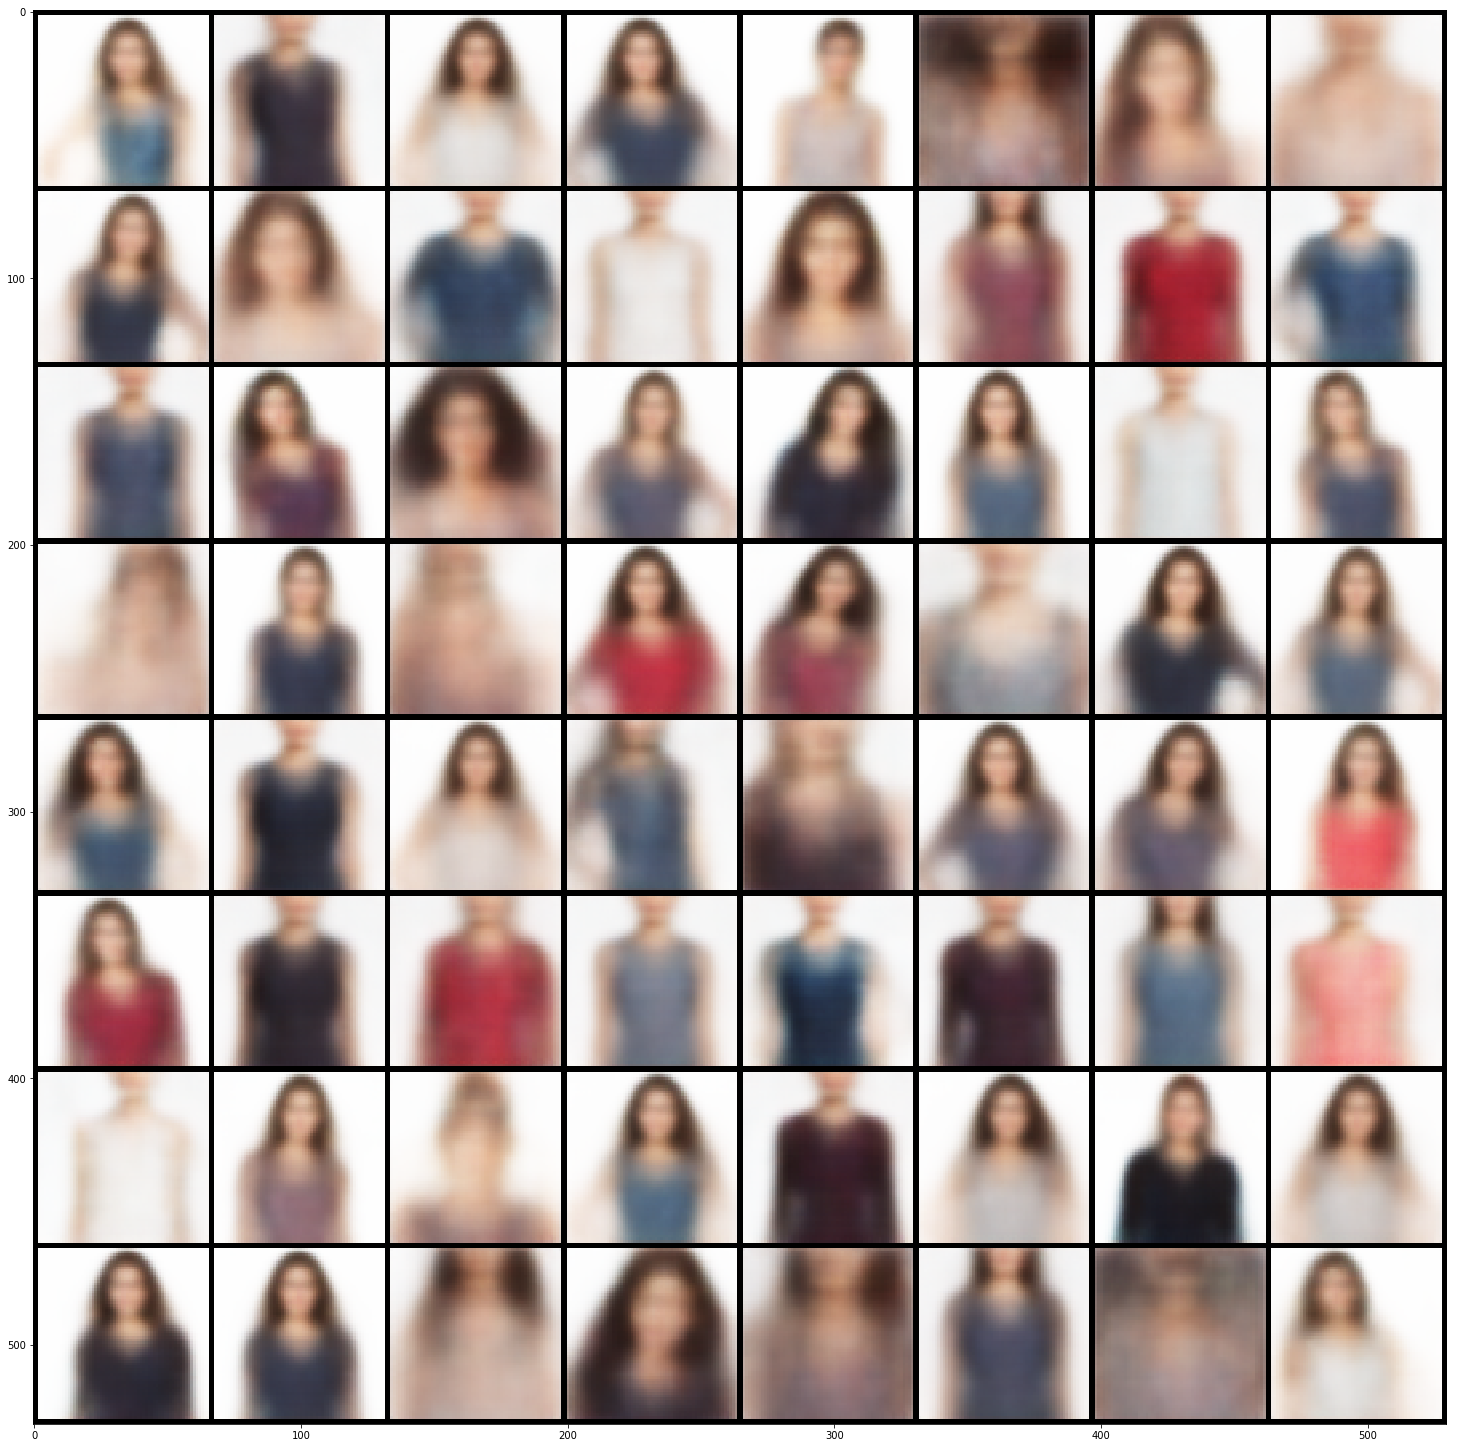

In [29]:
# Plot samples
samples = viz.samples()

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(samples.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/croptop_xint_64_e50_b200_c5d5_gam26_samples.png",dpi=200)

#### Traverses all latent dimensions one by one and plots a grid of images where each row corresponds to a latent traversal of one latent dimension

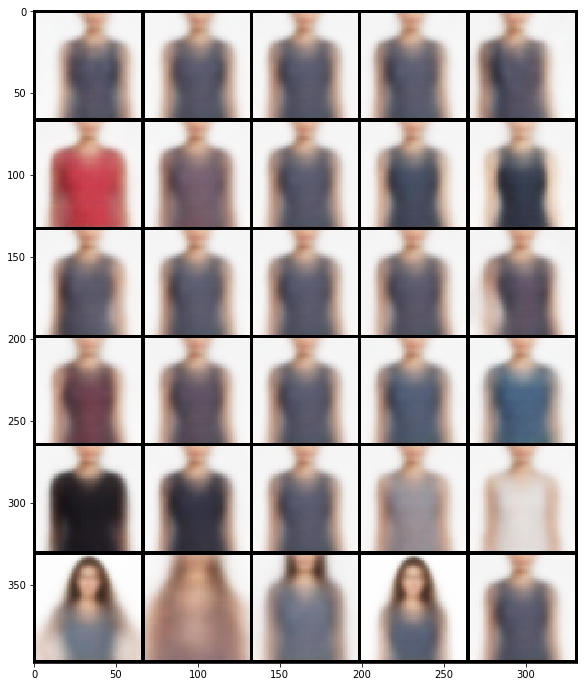

In [34]:
# Plot all traversals
traversals = viz.all_latent_traversals(size=5)

plt.figure(figsize=(12,12))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/croptop_xint_64_e50_b200_c5d5_gam26_all_traversals_n20.png",dpi=200)

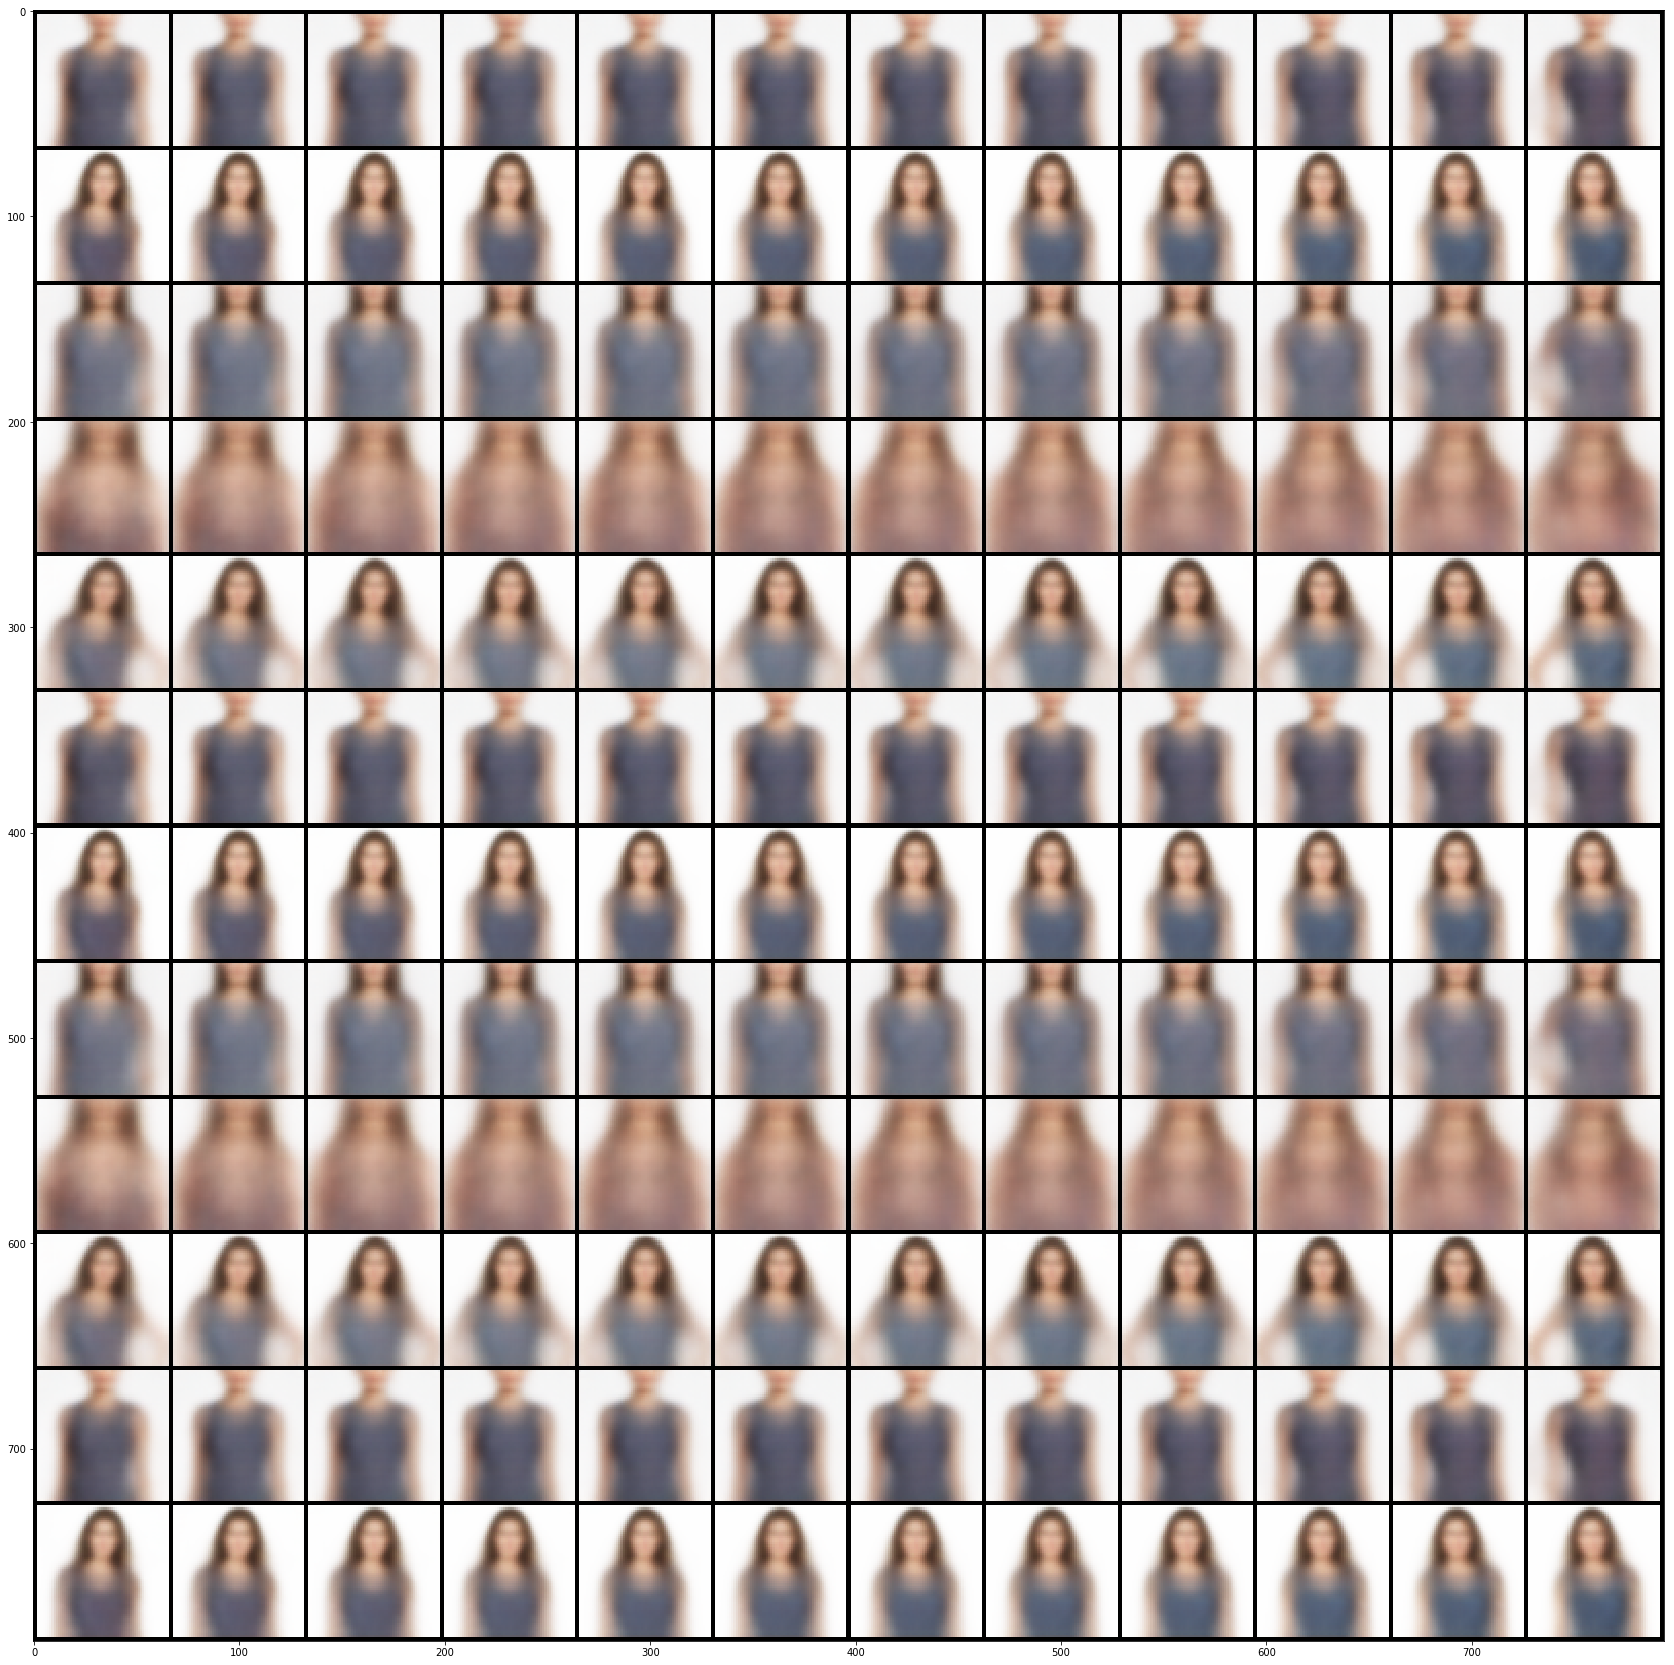

In [38]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(12, 12))

plt.figure(figsize=(30,30))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/croptop_xint_64_e50_b200_c5d5_gam26_traversals2100.png",dpi=200)

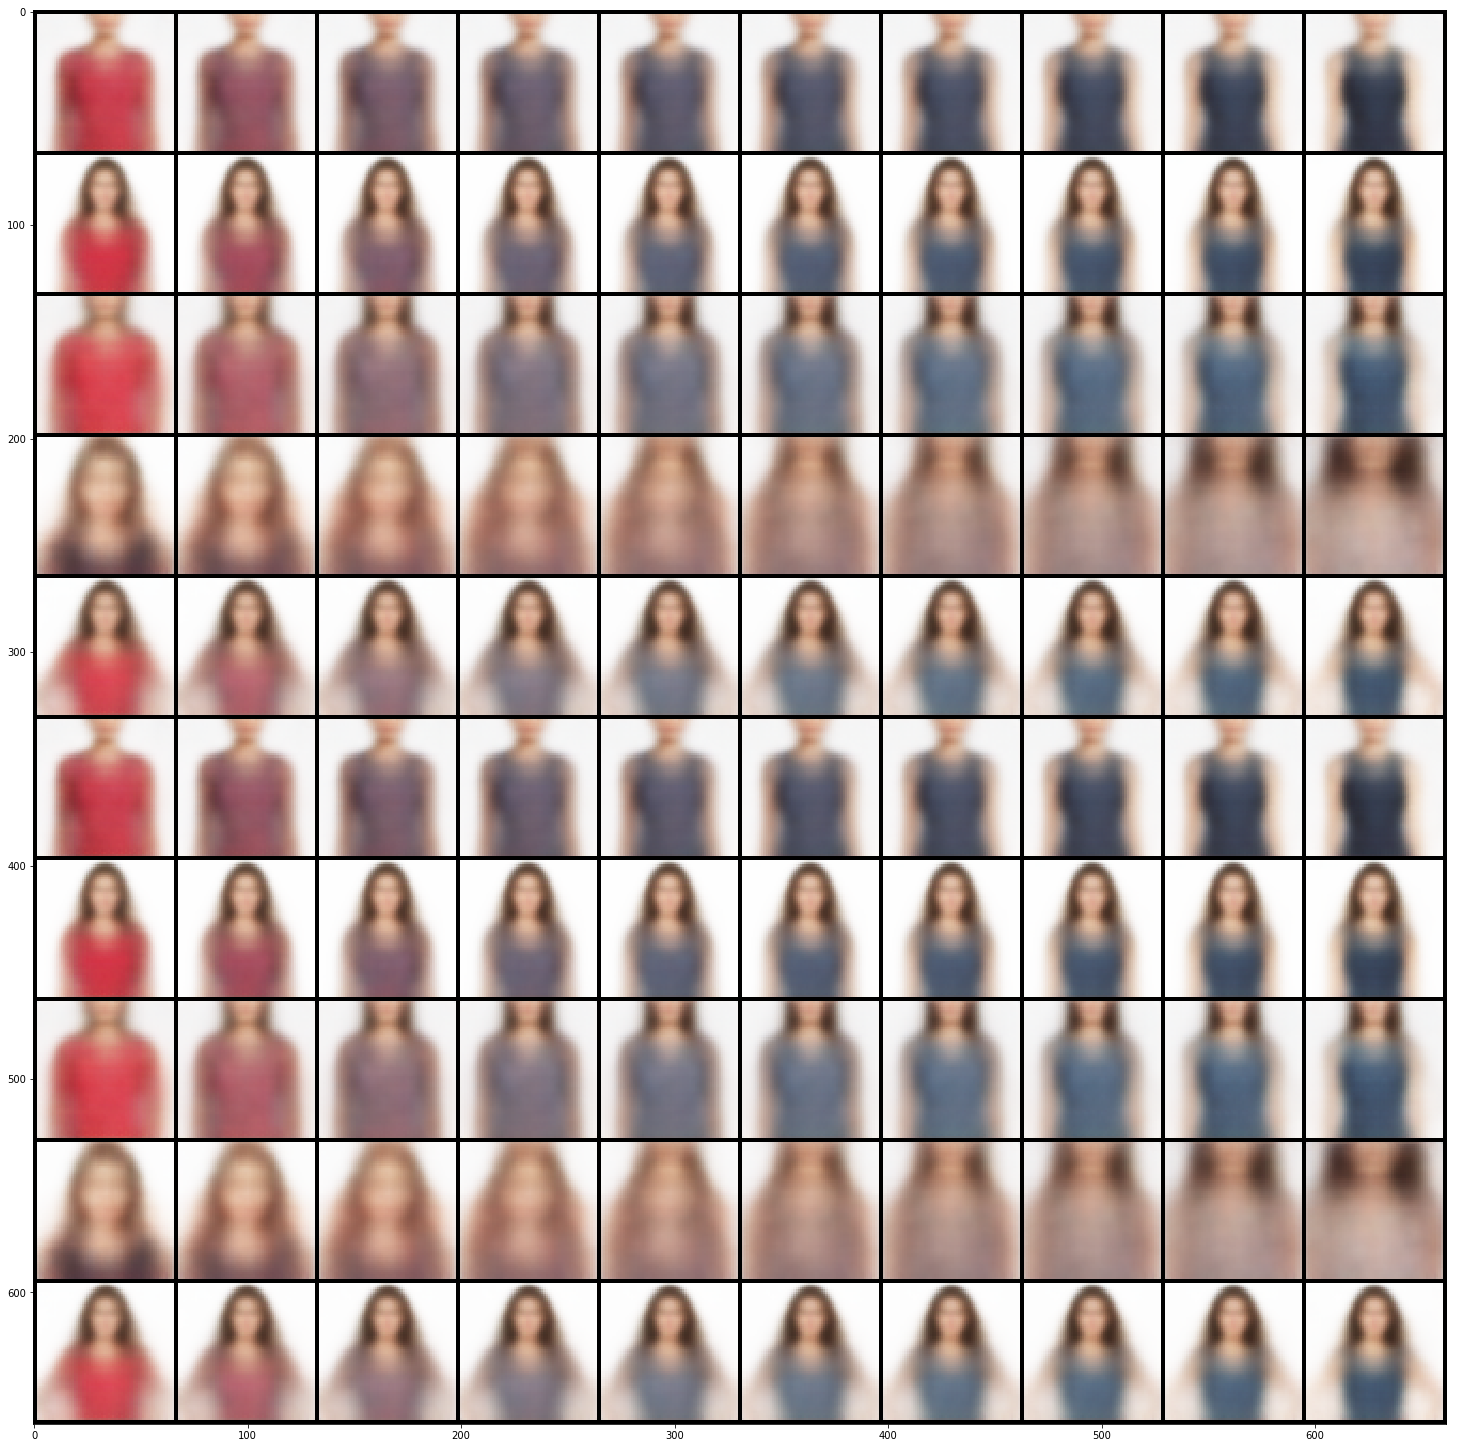

In [32]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=1, cont_axis=1, disc_idx=0, disc_axis=0, size=(12, 12))

plt.figure(figsize=(30,30))
plt.imshow(traversals.numpy()[0, :, :]);
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/croptop_xint_64_e50_b200_c5d5_gam26_traversals1100.png",dpi=200)

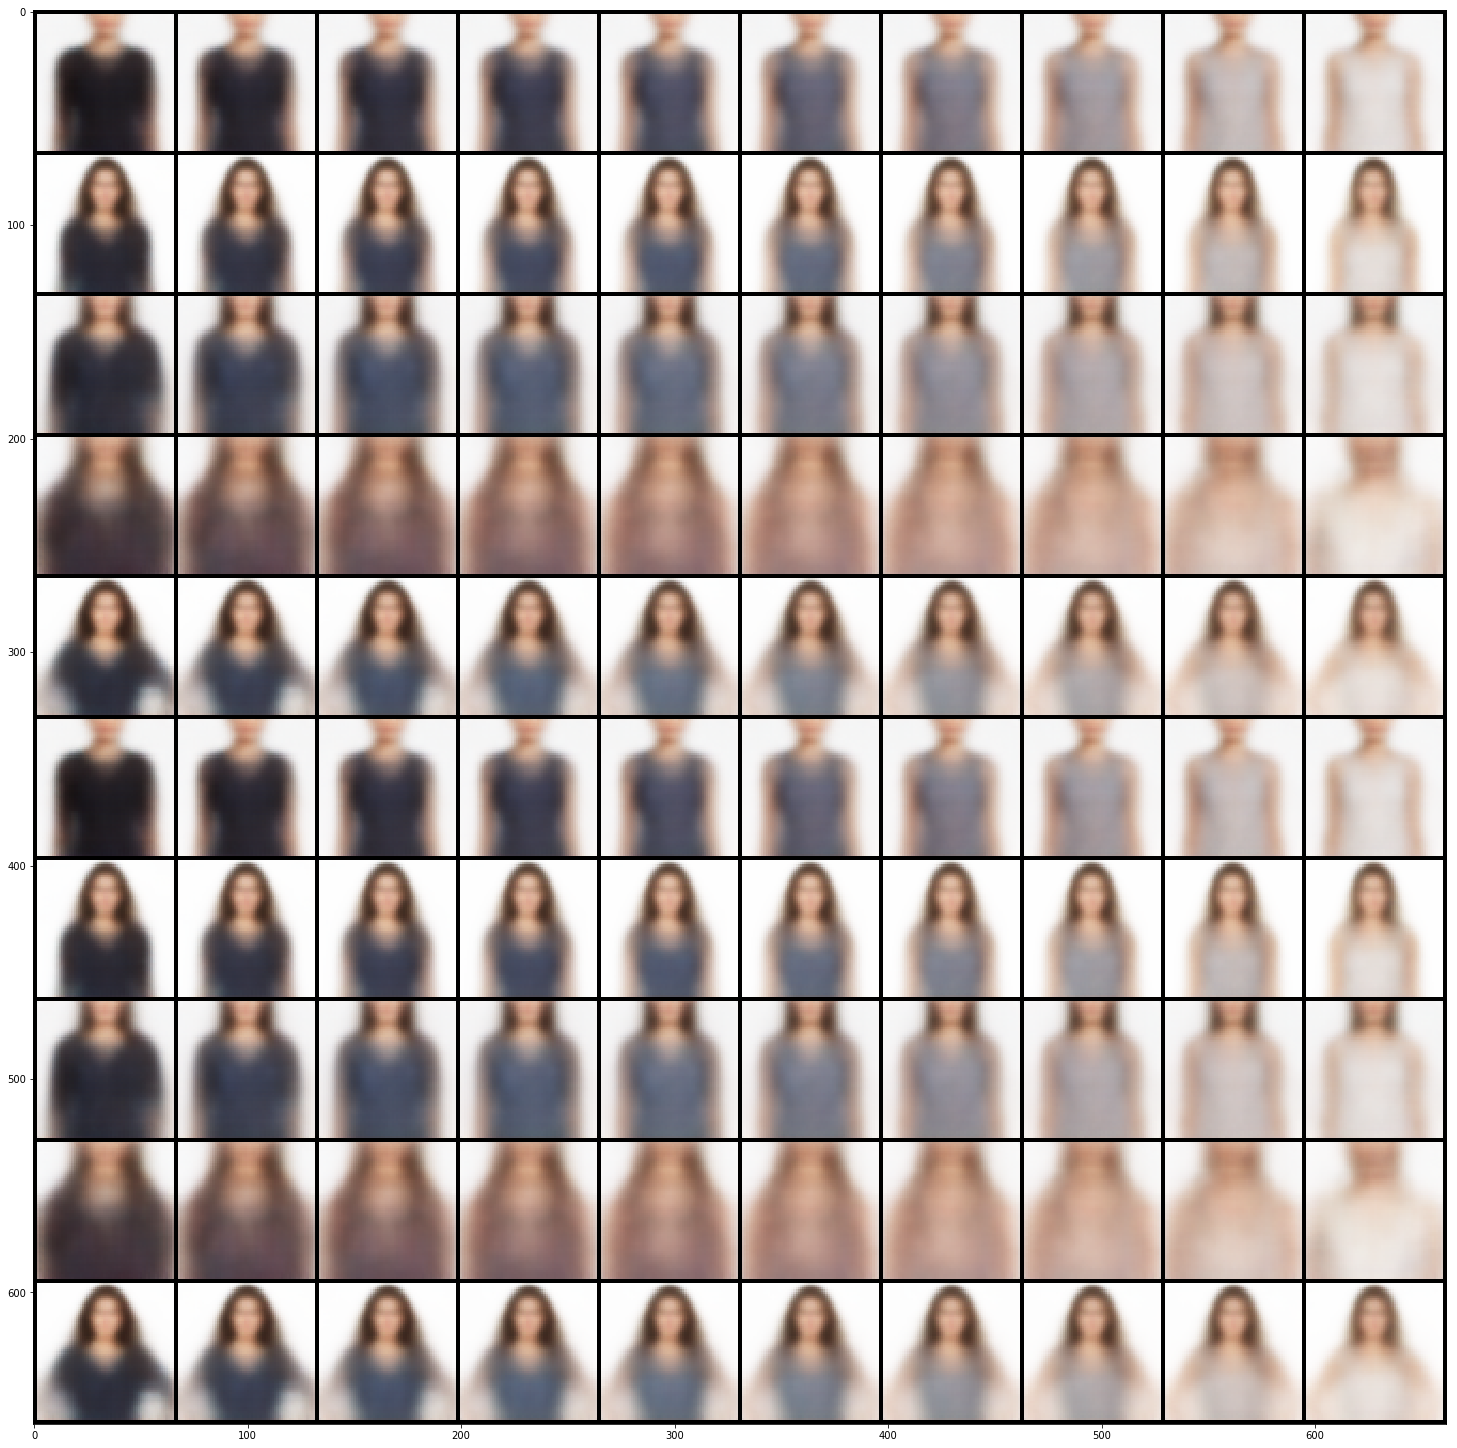

In [46]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=4, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(26,26))
#plt.imshow(traversals.numpy()[0, :, :], cmap='gray');
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/croptop_xint_64_e50_b200_c5d5_gam26_traversals4100.png",dpi=200)

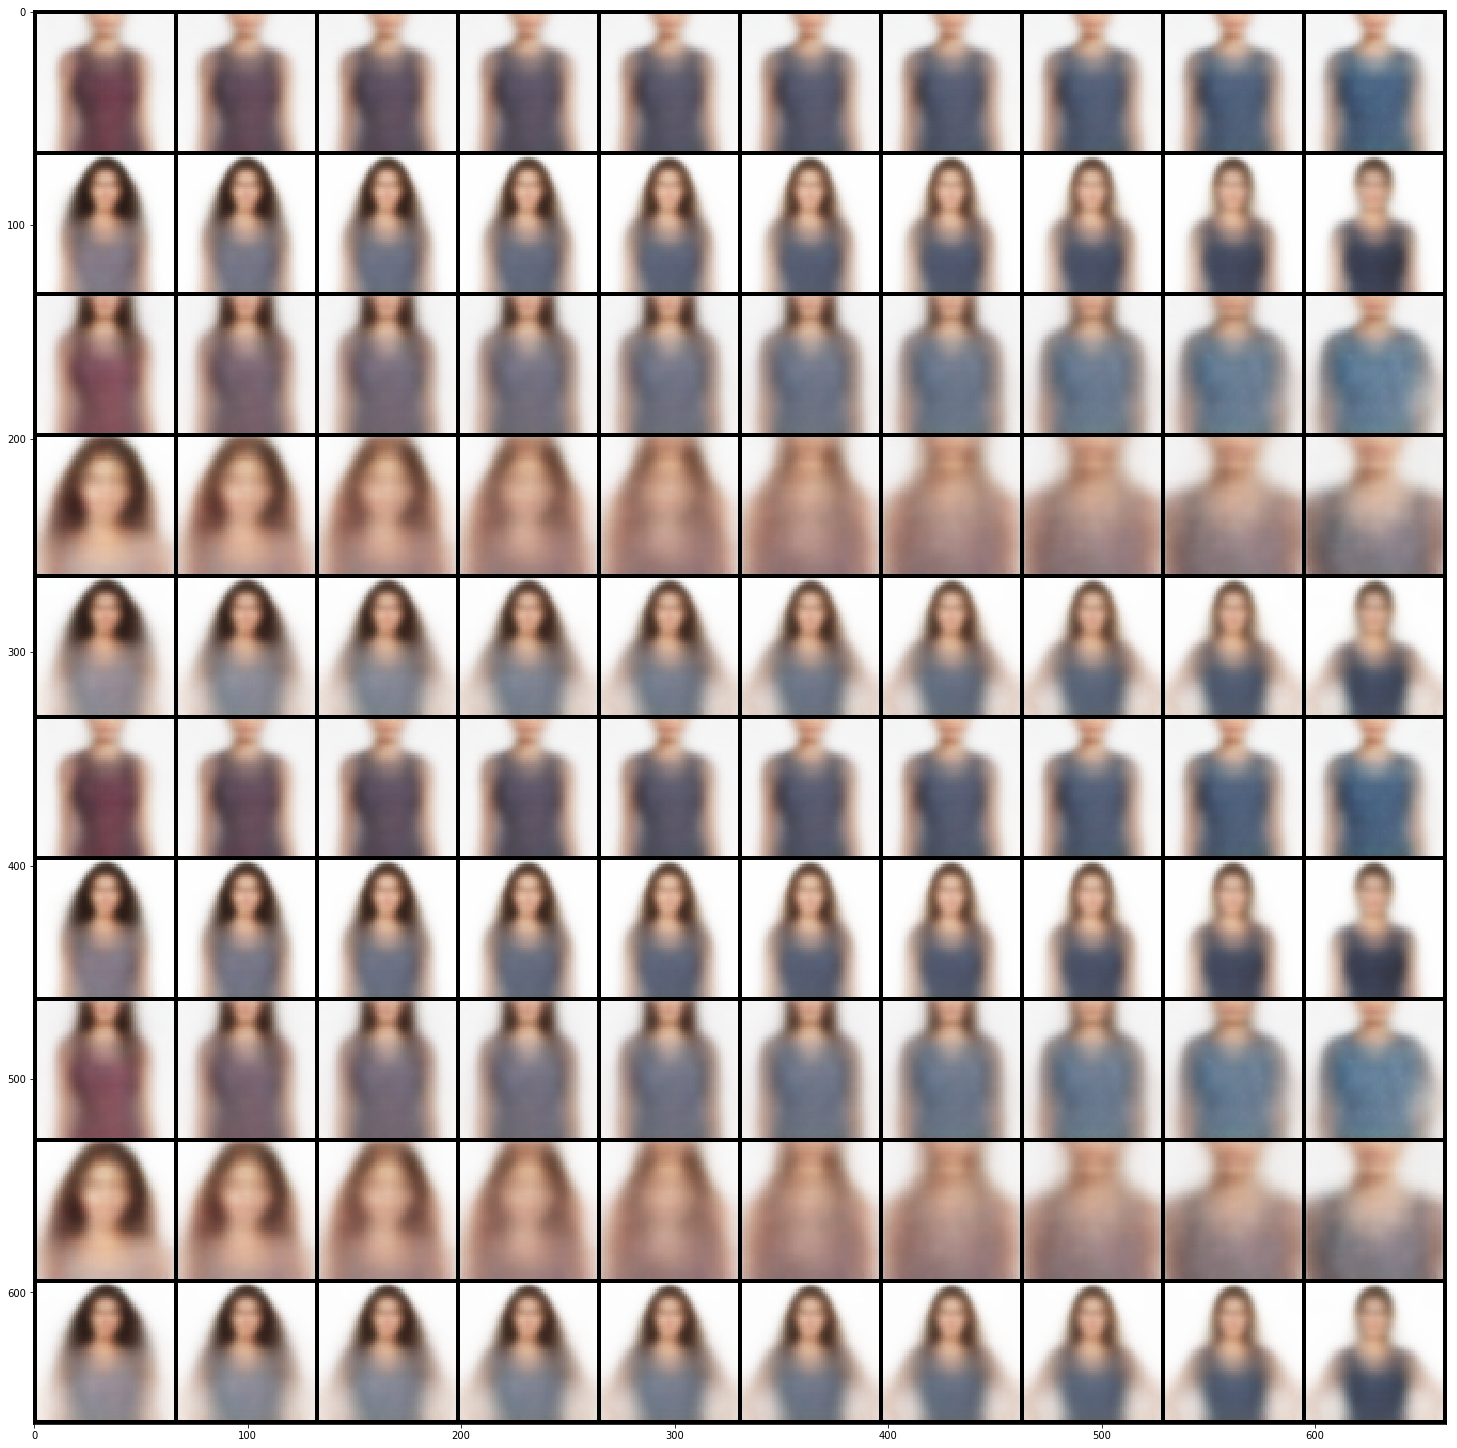

In [45]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=3, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(26,26))
#plt.imshow(traversals.numpy()[0, :, :], cmap='gray');
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/croptop_xint_64_e50_b200_c5d5_gam26_traversals3100.png",dpi=200)

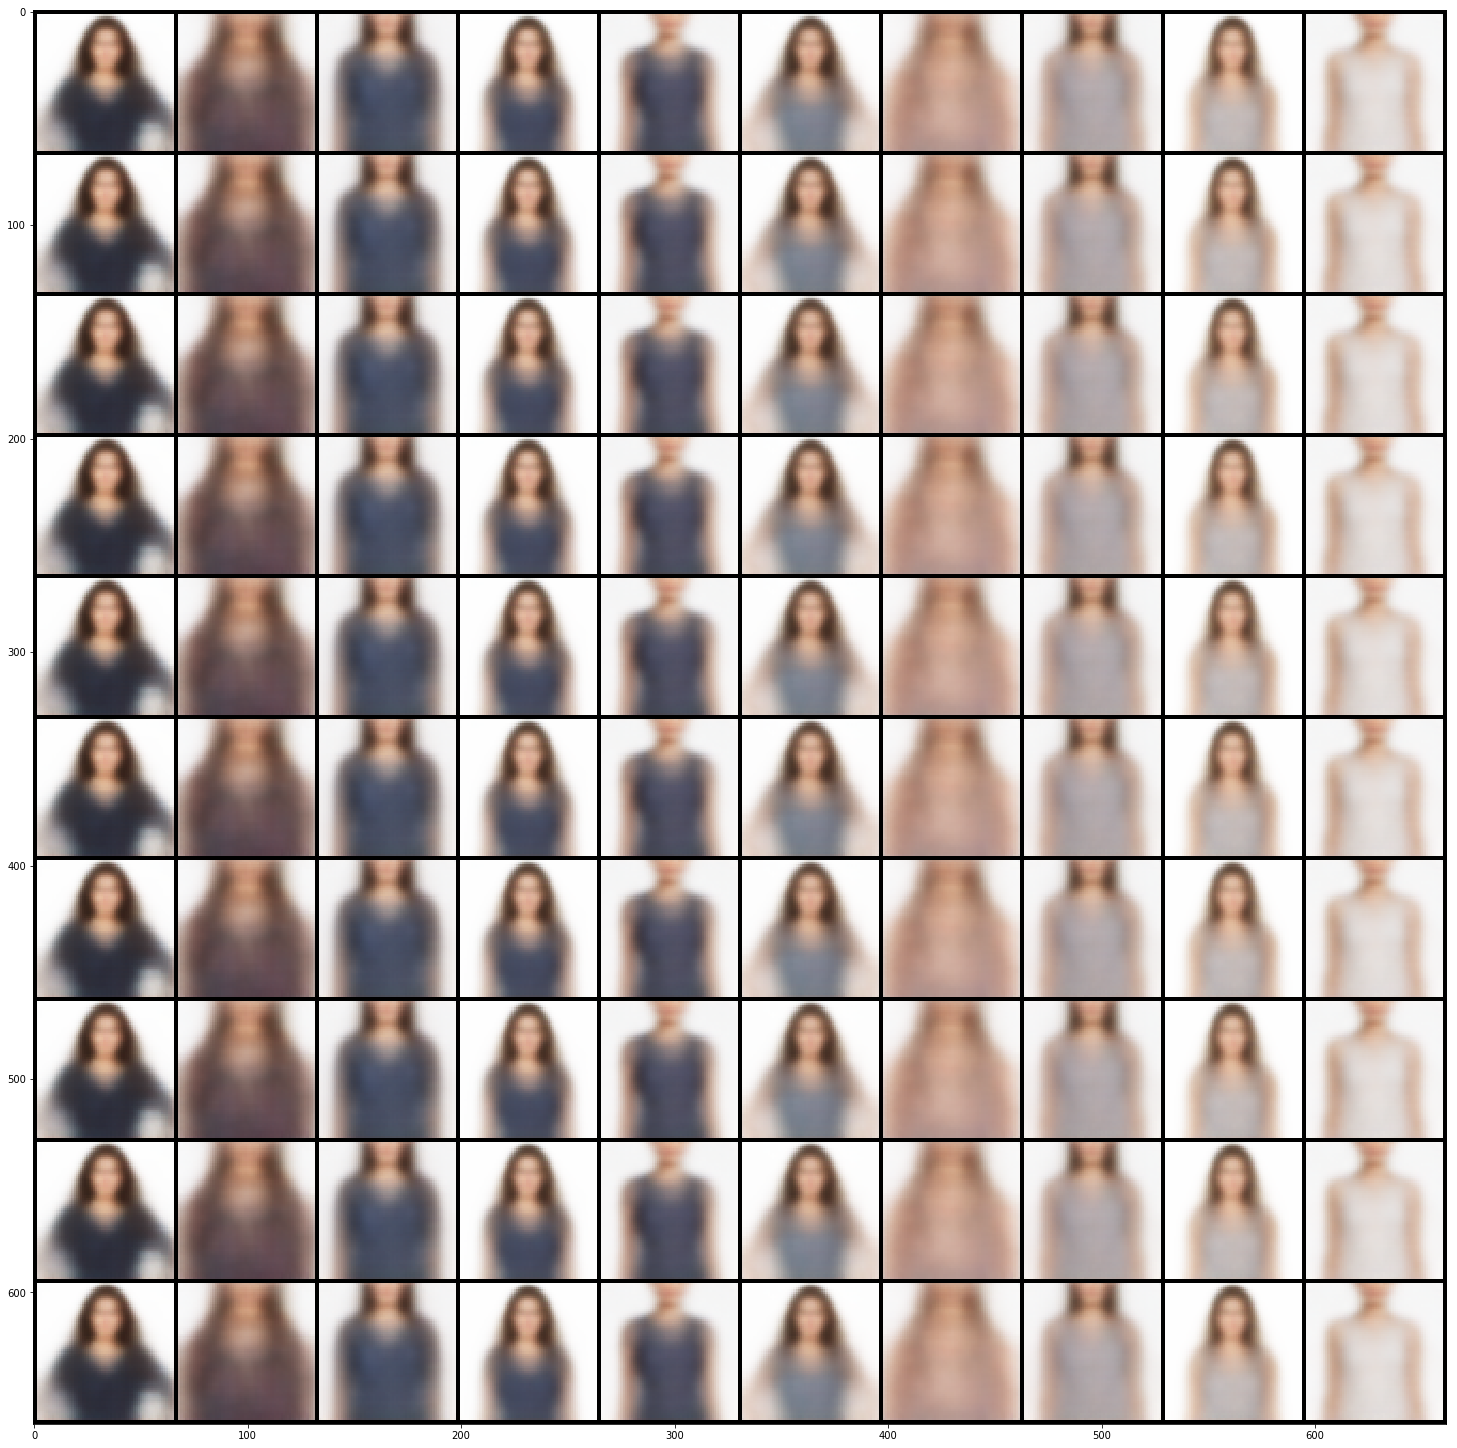

In [47]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=4, cont_axis=1, disc_idx=0, disc_axis=1, size=(10, 10))

plt.figure(figsize=(26,26))
#plt.imshow(traversals.numpy()[0, :, :], cmap='gray');
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/306/64/croptop_xint_64_e50_b200_c5d5_gam26_traversals4101.png",dpi=200)

In [ ]:
!ls

### Save Model

In [43]:
model_name = "croptop_xint_64_e50_b200_c5d5_gam26.pth"

In [44]:
torch.save(model.state_dict(),"trained_models/" + "statedict_" + model_name) # save state dict
#torch.save(model, model_name) # save full model

In [ ]:
print("Done training: ",model_name)

#### Restore Model from State Dict

In [ ]:
sd_model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64))
sd_model.load_state_dict(torch.load("statedict_" + model_name))

#### Restore Full Model
* Note in this case the serialized data is bound to the specific classes and exact directory strucutre used.

In [ ]:
full_model = torch.load(model_name)

In [ ]:
type(full_model)

In [ ]:
type(sd_model)

In [ ]:
!ls